# **Title:**

# Time-Series Demand Forecasting for E-Commerce Sales using LLM
__________

# 1. Problem Description
In today’s competitive e-commerce landscape, accurate demand forecasting is crucial for inventory management, supply chain optimization, and marketing strategy. This project focuses on predicting weekly product sales on the Wilberries platform using historical data spanning 2022 to 2024. The dataset includes detailed sales records along with product metadata (e.g., brand, rating, discount).

The goal is to model sales trends and forecast future weekly sales values, thereby enabling the platform to:

*   Anticipate stock needs
*   Optimize promotional campaigns
*   Prevent overstocking or understocking


The core challenge lies in capturing temporal patterns in sales data, which can be influenced by promotions, seasonality, product ratings, and discounts. Additionally, the dataset is high-dimensional with over 330+ features per record and exhibits substantial sparsity, necessitating robust preprocessing and model design.

In [90]:
#!pip3 install xgboost

In [91]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm holidays openmeteo-requests transformers sentence-transformers bertopic prophet

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import requests
import holidays
import datetime

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from bertopic import BERTopic
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 2. Dataset and Preprocessing
_____
## **Dataset Origin:**
Wilberries.com, an e-commerce platform.
Data Type: Sales data per product per day, along with metadata like seller, brand, rating, and discounts.

## **Preprocessing Steps:**

**Column Translation & Cleaning:** Translated and cleaned over 60+ irrelevant or verbose columns.

**Aggregation:** Daily sales were converted to weekly sales using pd.to_datetime() and resample('W').

**Missing Value Imputation:** Forward-filled missing values, used .fillna(0) for sales.

**Normalization:** MinMaxScaler() was applied for RNN-based models.

**Train-Test Split:** The data from 2022–2023 was used for training, while 2024 was reserved for testing.

## 2.1. Functions for Pre-Processing

In [93]:
## Functions


columns_to_drop = ['ID склейки','Промокод', 'СПП', 'Цена СПП', 'Цена с WB кошельком', 'FBS',
                'Subject ID', 'Позиция в категории', 'Страна', 'Ср. % выкупа с возвратами',
                'Средняя позиция в поиске', 'Макс. цена','Мин. цена','Потенциал',
                'Кол-во продаж на отзыв', 'Упущенная выручка','Упущенная выручка %', 'Ссылка', 'Фото',
               'Среднее при наличии','Кол-во фото','3d фото','Дата обнаружения','Дата первого отзыва','Видео',
               'Рейтинг карточки MPSTATS','Средний % выкупа','Кол-во слов в поиске','Видимость карточки','Кол-во рекламных слов в поиске',
                'Кол-во категорий','Средняя позиция в категориях','Кол-во акционных категорий','Кол-во размеров','Кол-во размеров в наличии',
                'Комиссия FBO','Комиссия FBS', 'Процент от выручки топовых товаров в предмете', 'Товары в связке',
               'Товары в связке в наличии','Средняя ставка в поиске','Средняя позиция в рекламных фразах', 'Кол-во складов',
               'Наличие во внешнией рекламе','Средняя позиция в органических фразах','Лучший час в продаж','Лучшая продажа',
                'Кол-во символов в описании','Кол-во символов в названии','Длина упаковки','Ширина упаковки','Высота упаковки','Наличие FBS',
               'Продажи, кол-во','Оборачиваемость','Оборачиваемость дн.','Стоимость замороженного остатка','Замороженный остаток',
                'Видимость в категориях', 'Цвет','Категория','Название','Среднее в день','Средняя дневная выручка', 'Предмет','Процент замороженного остатка',
                'Дней на сайте','Пол','Выручка','Был в наличии','Медиан. цена','Дней с продажами','Медиан. цена','Базовая цена','Средний рейтинг последних отзывов','Рейтинг',
                'Цена','Ср. цена','Наличие, шт.','Кол-во последних отрицательных отзывов в процентах','Цена со скидкой']

def process_data_frame(data):
    # Convert the "Rating" column to float
    if 'Rating' in data.columns:
        data['Rating'] = data['Rating'].astype(str).str.replace(',', '.').astype(float)

    # Convert the "Discounted Price" column to float
    if 'Discounted Price' in data.columns:
        data['Discounted Price'] = data['Discounted Price'].astype(str).str.replace(',', '.').astype(float)

    return data


def translate_columns(df, translations):
    """
    Translates the column names of a DataFrame based on the given translation dictionary.

    :param df: The DataFrame whose columns need to be translated.
    :param translations: A dictionary mapping original column names to their English translations.

    :return: The DataFrame with translated column names.
    """
    df = df.rename(columns=translations)

    # Additional replacements for specific patterns in column names
    if df is not None:
        df = df.rename(columns=lambda name: name.replace('Запросы', 'Requests'))
        df = df.rename(columns=lambda name: name.replace('Продажи', 'Sales'))
        df = df.rename(columns=lambda name: name.replace('Остатки', 'Inventory'))
        df = df.rename(columns=lambda name: name.replace('Выручка', 'Revenue'))

    return df

# Column translation dictionary
column_translations = {
    'Название': 'Name',
    'Категория': 'Category',
    'Бренд': 'Brand',
    'Продавец': 'Seller',
    'Цвет': 'Color',
    'Наличие, шт.': 'Stock, pcs',
    'Отзывы': 'Reviews',
    'Цена': 'Price',
    'Ср. цена': 'Avg Price',
    'Медиан. цена': 'Median Price',
    'Средняя дневная выручка': 'Avg Daily Revenue',
    'Дней на сайте': 'Days on Site',
    'Был в наличии': 'In Stock',
    'Дней с продажами': 'Days with Sales',
    'Рейтинг': 'Rating',
    'Скидка': 'Discount',
    'Цена со скидкой': 'Discounted Price',
    'Среднее в день': 'Avg per Day',
    'SKU': 'ProductID',
    'Дробный рейтинг': 'Rating'

}

def clean_data(data, columns_to_drop, column_translations):
    """Function to remove unnecessary columns and rename them"""

    # Drop specified columns
    data = data.drop(columns=columns_to_drop, errors='ignore')

    # Rename columns according to the provided map
    data = data.rename(columns=column_translations)

    # Replace parts of column names
    data = data.rename(columns=lambda name: name.replace('Запросы', 'Requests')
                                           .replace('Продажи', 'Sales')
                                           .replace('Остатки', 'Inventory')
                                           .replace('Выручка', 'Revenue')
                                           .replace('Цена', 'Price'))

    return data



def aggregate_data(data):
    """Function to aggregate the data"""
    # Perform aggregation by Seller
    grouped_data = data.groupby('ProductID').agg({
        'Seller':'first',
        'Brand': 'first',
        'Reviews':'sum',
        'Discount': 'mean',
        #'Discounted Price': 'mean',
        'Rating': 'mean',
        **{col: 'sum' for col in data.columns if 'Sales' in col},
        **{col: 'sum' for col in data.columns if 'Requests' in col},
        **{col: 'sum' for col in data.columns if 'Inventory' in col},
        **{col: 'mean' for col in data.columns if 'Price' in col},
        **{col: 'sum' for col in data.columns if 'Revenue' in col}
    }).reset_index()

    # Optionally drop columns after aggregation
    keywords = ['Inventory', 'Requests', 'Revenue']
    columns_to_drop = [col for col in grouped_data.columns if any(keyword in col for keyword in keywords)]
    grouped_data = grouped_data.drop(columns=columns_to_drop, errors='ignore')

    return grouped_data

def info_data(df):
    """function for outputting basic information about DataFrames"""
    print(f'\n\nNumber of features: {df.shape[1]}, Number of observations: {df.shape[0]}\n')
    print('Let is output the general information about the dataframe:')
    display(df.info())
    print('\nDisplay the first 5 rows:')
    display(df.head(5))
    print('\nDisplay the last 5 rows:')
    display(df.tail(5))
    print('\nCheck for missing values:')
    display(pd.DataFrame(df.isna().mean()*100,).style.background_gradient('BuPu'))
    print(f'\n\nNumber of complete duplicates in the data:')
    display(df.duplicated().sum())
    print('\n\nDescriptive statistics:')
    display(df.describe())

    num_cols, cat_cols = [], []
    for num, i in enumerate(df.columns):
        if pd.api.types.is_numeric_dtype(df[i]):
            print(f'{num+1}) {i} numerical), original values: {len(df[i].unique())}')
            num_cols.append(i)
        elif pd.api.types.is_object_dtype(df[i]):
            print(f'{num+1}) {i} (categorical), original values: {len(df[i].unique())}')
            cat_cols.append(i)
    print(f'\nTotal:\nnumerical: {len(num_cols)}\ncategorical: {len(cat_cols)}')

def combined_data_year(dataframes):
    """The function that combines data for the year and processes it """
    # Concatenate all DataFrames into one
    combined_data = pd.concat(dataframes, ignore_index=True)

    # Attempt to cast all columns containing 'Sales' in their name to integers
    sales_columns = [col for col in combined_data.columns if 'Sales' in col]
    for col in sales_columns:
        combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce').fillna(0).astype(int)

    # Attempt to cast all columns containing 'Price' in their name to integers
    price_columns = [col for col in combined_data.columns if 'Price' in col]
    for col in price_columns:
        combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce').fillna(0).astype(int)

    # Compute averages and first entries, ensuring float formatting for 'Discount' and 'Rating'
    result = combined_data.groupby(['ProductID'], as_index=False).agg({
        'Seller': 'first',
        'Brand': 'first',
        'Reviews':'sum',
        'Discount': 'mean',
        'Rating': 'mean',
        **{col: 'sum' for col in sales_columns},
        **{col: 'mean' for col in price_columns}
    })

    # Format 'Discount' and 'Rating' to one decimal place
    result['Discount'] = result['Discount'].round(1)
    result['Rating'] = result['Rating'].round(1)

    # Rename columns that contain 'Sales' or 'Price'
    new_columns = []
    for col in result.columns:
        parts = col.split()
        if len(parts) == 2:
            date_str, category = parts
            try:
                # Parse the date
                date_obj = pd.to_datetime(date_str, format='%d.%m.%Y')
                # Format the new column name with date and category
                new_col_name = f"{date_obj.strftime('%Y-%m-%d')} {category}"
                new_columns.append(new_col_name)
            except ValueError:
                # In case of a parsing error, retain the original column name
                new_columns.append(col)
        else:
            # If the column does not match the expected format, retain the original column name
            new_columns.append(col)

    # Apply the renamed columns to the dataframe
    result.columns = new_columns

    return result





## 2.2. Datasets 2022

In [94]:
data_01_2022 = pd.read_csv('sales_01_2022.csv', sep=';')
data_02_2022 = pd.read_csv('sales_02_2022.csv', sep=';')
data_03_2022 = pd.read_csv('sales_03_2022.csv', sep=';')
data_04_2022 = pd.read_csv('sales_04_2022.csv', sep=';')
data_05_2022 = pd.read_csv('sales_05_2022.csv', sep=';')
data_06_2022 = pd.read_csv('sales_06_2022.csv', sep=';')
data_07_2022 = pd.read_csv('sales_07_2022.csv', sep=';')
data_08_2022 = pd.read_csv('sales_08_2022.csv', sep=';')
data_09_2022 = pd.read_csv('sales_09_2022.csv', sep=';')
data_10_2022 = pd.read_csv('sales_10_2022.csv', sep=';')
data_11_2022 = pd.read_csv('sales_11_2022.csv', sep=';')
data_12_2022 = pd.read_csv('sales_12_2022.csv', sep=';')

<ipython-input-94-6bb746f36274>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_01_2022 = pd.read_csv('sales_01_2022.csv', sep=';')
<ipython-input-94-6bb746f36274>:2: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data_02_2022 = pd.read_csv('sales_02_2022.csv', sep=';')
<ipython-input-94-6bb746f36274>:3: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data_03_2022 = pd.read_csv('sales_03_2022.csv', sep=';')
<ipython-input-94-6bb746f36274>:4: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data_04_2022 = pd.read_csv('sales_04_2022.csv', sep=';')
<ipython-input-94-6bb746f36274>:5: DtypeWarning: Columns (16,47) have mixed types. Specify dtype option on import or set low_memory=False.
  data_05_2022 = pd.read_csv('sales_05_2022.csv', sep=';')
<ipython-inpu

In [95]:
# data_02_2022
# 1 Drop columns
data_02_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_02_2022
data_02_2022 = translate_columns(data_02_2022, column_translations)
# 3 Chacge types
data_02_2022 = process_data_frame(data_02_2022)
# 4 Drop  unnecessary columns and rename them
data_02_2022 = clean_data(data_02_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_02_2022 = aggregate_data(data_02_2022)

# data_03_2022
# 1 Drop columns
data_03_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_03_2022
data_03_2022 = translate_columns(data_03_2022, column_translations)
# 3 Chacge types
data_03_2022 = process_data_frame(data_03_2022)
# 4 Drop  unnecessary columns and rename them
data_03_2022 = clean_data(data_03_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_03_2022 = aggregate_data(data_03_2022)

# data_04_2022
# 1 Drop columns
data_04_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_04_2022
data_04_2022  = translate_columns(data_04_2022, column_translations)
# 3 Chacge types
data_04_2022 = process_data_frame(data_04_2022)
# 4 Drop  unnecessary columns and rename them
data_04_2022 = clean_data(data_04_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_04_2022 = aggregate_data(data_04_2022)


# data_05_2022
# 1 Drop columns
data_05_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_05_2022
data_05_2022 = translate_columns(data_05_2022, column_translations)
# 3 Chacge types
data_05_2022 = process_data_frame(data_05_2022)
# 4 Drop  unnecessary columns and rename them
data_05_2022 = clean_data(data_05_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_05_2022 = aggregate_data(data_05_2022)


# data_06_2022
# 1 Drop columns
data_06_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_06_2022
data_06_2022 = translate_columns(data_06_2022, column_translations)
# 3 Chacge types
data_06_2022 = process_data_frame(data_06_2022)
# 4 Drop  unnecessary columns and rename them
data_06_2022 = clean_data(data_06_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_06_2022 = aggregate_data(data_06_2022)


# data_07_2022
# 1 Drop columns
data_07_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_07_2022
data_07_2022 = translate_columns(data_07_2022, column_translations)
# 3 Chacge types
data_07_2022 = process_data_frame(data_07_2022)
# 4 Drop  unnecessary columns and rename them
data_07_2022 = clean_data(data_07_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_07_2022 = aggregate_data(data_07_2022)


# data_08_2022
# 1 Drop columns
data_08_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_08_2022
data_08_2022 = translate_columns(data_08_2022, column_translations)
# 3 Chacge types
data_08_2022 = process_data_frame(data_08_2022)
# 4 Drop  unnecessary columns and rename them
data_08_2022 = clean_data(data_08_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_08_2022 = aggregate_data(data_08_2022)


# data_09_2022
# 1 Drop columns
data_09_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_09_2022
data_09_2022  = translate_columns(data_09_2022, column_translations)
# 3 Chacge types
data_09_2022  = process_data_frame(data_09_2022)
# 4 Drop  unnecessary columns and rename them
data_09_2022 = clean_data(data_09_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_09_2022 = aggregate_data(data_09_2022)


# data_10_2022
# 1 Drop columns
data_10_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_10_2022
data_10_2022 = translate_columns(data_10_2022, column_translations)
# 3 Chacge types
data_10_2022 = process_data_frame(data_10_2022)
# 4 Drop  unnecessary columns and rename them
data_10_2022 = clean_data(data_10_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_10_2022 = aggregate_data(data_10_2022)


# data_11_2022
# 1 Drop columns
data_11_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_11_2022
data_11_2022 = translate_columns(data_11_2022, column_translations)
# 3 Chacge types
data_11_2022 = process_data_frame(data_11_2022)
# 4 Drop  unnecessary columns and rename them
data_11_2022 = clean_data(data_11_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_11_2022 = aggregate_data(data_11_2022)


# data_12_2022
# 1 Drop columns
data_12_2022.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_12_2022
data_12_2022 = translate_columns(data_12_2022, column_translations)
# 3 Chacge types
data_12_2022 = process_data_frame(data_12_2022)
# 4 Drop  unnecessary columns and rename them
data_12_2022 = clean_data(data_12_2022, columns_to_drop, column_translations)
# 5 Goup by seller
data_12_2022 = aggregate_data(data_12_2022)
data_12_2022


,ProductID,Seller,Brand,Reviews,Discount,Rating,01.12.2022 Sales,02.12.2022 Sales,03.12.2022 Sales,04.12.2022 Sales,...,22.12.2022 Price,23.12.2022 Price,24.12.2022 Price,25.12.2022 Price,26.12.2022 Price,27.12.2022 Price,28.12.2022 Price,29.12.2022 Price,30.12.2022 Price,31.12.2022 Price
0,526276,ООО Вайлдберриз,Tamaris,31,40.0,3.4,0,0,0,0,...,4218.0,4218.0,4218.0,4218.0,3894.0,3894.0,3894.0,3894.0,3894.0,3894.0
1,1184016,ООО Инвест-Трейд,PUSHA,3,0.0,5.0,0,0,0,0,...,11400.0,11400.0,11400.0,11400.0,11400.0,11400.0,11400.0,0.0,0.0,0.0
2,2257134,ООО Вайлдберриз,XTI,10,65.0,2.5,0,0,0,0,...,1466.0,1466.0,1466.0,1466.0,1466.0,1351.0,1351.0,1351.0,1351.0,1351.0
3,2264788,ООО Вайлдберриз,Pegia,7,69.0,3.4,0,0,0,0,...,4473.0,4473.0,4473.0,4473.0,4473.0,4473.0,4473.0,4473.0,4473.0,4473.0
4,2264789,ООО Вайлдберриз,Pegia,7,37.0,3.4,0,0,0,0,...,9812.0,9812.0,9812.0,9812.0,9812.0,9090.0,9090.0,9090.0,9090.0,9090.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10295,141737749,ИП Мамаева А М,lovinso,0,40.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5700.0
10296,141738159,ИП Мамаева А М,lovinso,0,40.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5700.0
10297,141748722,RM,Salina,0,0.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10298,141748723,RM,Salina,0,0.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Conbined dataset 2022

In [96]:
# Gather all monthly DataFrames into a list
dataframes = [
    data_02_2022, data_03_2022, data_04_2022,
    data_05_2022, data_06_2022, data_07_2022, data_08_2022,
    data_09_2022, data_10_2022, data_11_2022, data_12_2022
]


final_data_2022 = combined_data_year(dataframes)

In [97]:
# Display
final_data_2022.head(30)

,ProductID,Seller,Brand,Reviews,Discount,Rating,2022-02-01 Sales,2022-02-02 Sales,2022-02-03 Sales,2022-02-04 Sales,...,2022-12-22 Price,2022-12-23 Price,2022-12-24 Price,2022-12-25 Price,2022-12-26 Price,2022-12-27 Price,2022-12-28 Price,2022-12-29 Price,2022-12-30 Price,2022-12-31 Price
0,526276,ООО Вайлдберриз,Tamaris,341,19.9,3.5,0,0,0,0,...,383.454545,383.454545,383.454545,383.454545,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
1,749658,ООО Вайлдберриз,UGG,125,0.0,4.0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1184016,ООО Вайлдберриз,PUSHA,33,0.0,5.0,0,0,0,0,...,1036.363636,1036.363636,1036.363636,1036.363636,1036.363636,1036.363636,1036.363636,0.000000,0.000000,0.000000
3,2257134,ООО Вайлдберриз,XTI,110,56.4,2.7,0,0,0,0,...,133.272727,133.272727,133.272727,133.272727,133.272727,122.818182,122.818182,122.818182,122.818182,122.818182
4,2257135,ООО Вайлдберриз,XTI,100,55.5,2.8,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2264764,ООО Вайлдберриз,Pegia,252,29.3,4.2,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2264788,ООО Вайлдберриз,Pegia,77,44.4,3.5,0,0,0,0,...,406.636364,406.636364,406.636364,406.636364,406.636364,406.636364,406.636364,406.636364,406.636364,406.636364
7,2264789,ООО Вайлдберриз,Pegia,77,27.6,3.5,0,0,0,0,...,892.000000,892.000000,892.000000,892.000000,892.000000,826.363636,826.363636,826.363636,826.363636,826.363636
8,2265466,ООО Вайлдберриз,Pegia,11,37.7,4.1,0,0,0,0,...,406.636364,406.636364,406.636364,406.636364,406.636364,367.272727,367.272727,367.272727,367.272727,367.272727
9,2265474,ООО Вайлдберриз,Pegia,54,47.7,3.2,0,0,0,0,...,721.111111,721.111111,721.111111,721.111111,721.111111,661.000000,661.000000,661.000000,661.000000,661.000000


### Clean final_dataset 2022

In [98]:
# info_data(final_data_2022)

### Total sales 2022

To add a "Total_sales" row that aggregates and summarizes data from previous records in a table

In [99]:
# 1. Select only the date columns (formatted as YYYY-MM-DD)
date_columns = final_data_2022.columns[final_data_2022.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# 2. Calculate total sales per day (sum across sellers)
daily_sales = final_data_2022[date_columns].sum()

# 3. Calculate total sales for the entire period
total_sales = daily_sales.sum()

# 4. Calculate average rating (excluding zeros)
mean_rating = final_data_2022['Rating'][final_data_2022['Rating'] > 0].mean()

# 5. Calculate average discount (excluding zeros)
mean_discount = final_data_2022['Discount'][final_data_2022['Discount'] > 0].mean()

# Output
print("Total sales by day:")
print(daily_sales)

print(f"\nTotal sales for the entire period: {total_sales}")
print(f"Average rating (excluding zeros): {mean_rating:.2f}")
print(f"Average discount (excluding zeros): {mean_discount:.2f}")




Total sales by day:
2022-02-01 Sales    1.021000e+03
2022-02-02 Sales    1.030000e+03
2022-02-03 Sales    1.097000e+03
2022-02-04 Sales    7.730000e+02
2022-02-05 Sales    9.920000e+02
                        ...     
2022-12-27 Price    1.374791e+07
2022-12-28 Price    1.100210e+07
2022-12-29 Price    1.226692e+07
2022-12-30 Price    1.237232e+07
2022-12-31 Price    1.259805e+07
Length: 668, dtype: float64

Total sales for the entire period: 1580829222.7576475
Average rating (excluding zeros): 3.42
Average discount (excluding zeros): 46.94


### Plot: Daily sales



In [100]:
# #Plot a line chart of daily sales
# plt.figure(figsize=(10, 6))
# plt.plot(daily_sales.index, daily_sales.values, marker='o', linestyle='-', color='b', label='Sales')

# plt.title('Daily Sales Over Time')
# plt.xlabel('Date')
# plt.ylabel('Total Sales')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.grid(True)
# plt.legend()

# # Display the plot
# plt.show()


### Weekly sales

In [101]:
# # Step 1: Identify date columns
# date_columns = final_data_2022.columns[final_data_2022.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# # Step 2: Reshape the DataFrame to long format
# df_long = final_data_2022.melt(
#     id_vars=['Seller', 'Brand', 'Discount', 'Rating'],
#     value_vars=date_columns,
#     var_name='Date',
#     value_name='Sales'
# )

# # Step 3: Convert and prepare data
# df_long['Sales'] = pd.to_numeric(df_long['Sales'], errors='coerce').fillna(0).astype(int)
# df_long['Date'] = pd.to_datetime(df_long['Date'])
# df_long['WeekStart'] = df_long['Date'] - pd.to_timedelta(df_long['Date'].dt.dayofweek, unit='days')
# df_long['WeekEnd'] = df_long['WeekStart'] + pd.Timedelta(days=6)
# df_long['WeekRange'] = df_long['WeekStart'].dt.strftime('%Y-%m-%d') + ' to ' + df_long['WeekEnd'].dt.strftime('%Y-%m-%d')

# # Step 4: Group sales by week, seller, and brand
# weekly_sales = df_long.groupby(['Seller', 'Brand', 'WeekRange'], as_index=False)['Sales'].sum()

# # Step 5: Pivot the data so each week range becomes a separate column
# final_data_2022_weekly = weekly_sales.pivot(
#     index=['Seller', 'Brand'],
#     columns='WeekRange',
#     values='Sales'
# ).fillna(0).astype(int).reset_index()

# # Step 6: Restore Discount and Rating columns by merging from original dataset
# meta_info = final_data_2022[['Seller', 'Brand', 'Discount', 'Rating']].drop_duplicates()
# final_data_2022_weekly = final_data_2022_weekly.merge(meta_info, on=['Seller', 'Brand'], how='left')

# # Step 7: Reorder columns for readability
# cols = ['Seller', 'Brand', 'Discount', 'Rating'] + [col for col in final_data_2022_weekly.columns if col not in ['Seller', 'Brand', 'Discount', 'Rating']]
# final_data_2022_weekly = final_data_2022_weekly[cols]

# # Resulting DataFrame is ready
# final_data_2022_weekly


In [102]:
print(final_data_2022.columns)

Index(['ProductID', 'Seller', 'Brand', 'Reviews', 'Discount', 'Rating',
       '2022-02-01 Sales', '2022-02-02 Sales', '2022-02-03 Sales',
       '2022-02-04 Sales',
       ...
       '2022-12-22 Price', '2022-12-23 Price', '2022-12-24 Price',
       '2022-12-25 Price', '2022-12-26 Price', '2022-12-27 Price',
       '2022-12-28 Price', '2022-12-29 Price', '2022-12-30 Price',
       '2022-12-31 Price'],
      dtype='object', length=674)


### PlotPlot: weekly sales 2022 of sellers

In [103]:
# # Assuming `weekly_sales` is a DataFrame after grouping and summation

# plt.figure(figsize=(14, 8))

# # Ensure that 'WeekRange' is treated as a categorical variable ordered correctly
# weekly_sales['WeekRange'] = pd.Categorical(weekly_sales['WeekRange'],
#                                            categories=sorted(weekly_sales['WeekRange'].unique()),
#                                            ordered=True)

# # Plot a line graph for each seller
# sns.lineplot(data=weekly_sales, x='WeekRange', y='Sales', hue='Seller', marker='o')

# # Adjust the plot settings
# plt.xticks(rotation=45)  # Rotate the weekly range labels
# plt.title('Weekly Sales by Seller')
# plt.xlabel('Week Range')
# plt.ylabel('Sales')

# # Move the legend to the bottom
# plt.legend(title='Seller', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# # Adjust layout to fit everything
# plt.tight_layout()

# # Display the plot
# plt.show()


### Plot: total weekly sales 2022

In [104]:
# # 1. Select columns with dates in YYYY-MM-DD format
# date_columns = final_data_2022.columns[final_data_2022.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# # 2. Calculate daily sales
# daily_sales = final_data_2022[date_columns].sum()

# # Convert index to a datetime format
# daily_sales.index = pd.to_datetime(daily_sales.index)

# # 3. Group data by week and calculate weekly total sales
# weekly_sales = daily_sales.resample('W').sum()

# # 4. Plot the weekly sales graph
# plt.figure(figsize=(10, 6))
# plt.plot(weekly_sales.index, weekly_sales.values, marker='o', linestyle='-', color='b', label='Weekly Sales')

# plt.title('Weekly Sales Over Time')
# plt.xlabel('Week')
# plt.ylabel('Total Sales')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.grid(True)
# plt.legend()

# # Display the plot
# plt.show()



## 2.3.Datasets 2023

In [105]:
data_01_2023 = pd.read_csv('./sales_01_2023.csv', sep=';')
data_02_2023 = pd.read_csv('./sales_02_2023.csv', sep=';')
data_03_2023 = pd.read_csv('./sales_03_2023.csv', sep=';')
data_04_2023 = pd.read_csv('./sales_04_2023.csv', sep=';')
data_05_2023 = pd.read_csv('./sales_05_2023.csv', sep=';')
data_06_2023 = pd.read_csv('./sales_06_2023.csv', sep=';')
data_07_2023 = pd.read_csv('./sales_07_2023.csv', sep=';')
data_08_2023 = pd.read_csv('./sales_08_2023.csv', sep=';')
data_09_2023 = pd.read_csv('./sales_09_2023.csv', sep=';')
data_10_2023 = pd.read_csv('./sales_10_2023.csv', sep=';')
data_11_2023 = pd.read_csv('./sales_11_2023.csv', sep=';')
data_12_2023 = pd.read_csv('./sales_12_2023.csv', sep=';')

<ipython-input-105-ad0379dba404>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_01_2023 = pd.read_csv('./sales_01_2023.csv', sep=';')
<ipython-input-105-ad0379dba404>:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_02_2023 = pd.read_csv('./sales_02_2023.csv', sep=';')
<ipython-input-105-ad0379dba404>:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_03_2023 = pd.read_csv('./sales_03_2023.csv', sep=';')
<ipython-input-105-ad0379dba404>:4: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_04_2023 = pd.read_csv('./sales_04_2023.csv', sep=';')
<ipython-input-105-ad0379dba404>:5: DtypeWarning: Columns (13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_05_2023 = pd.read_csv('./sales_05_2023.csv', sep=';')
<ipy

In [106]:
data_12_2023.head(3)

,SKU,ID склейки,Название,Категория,Бренд,Продавец,Цвет,"Наличие, шт.",Наличие FBS,Отзывы,...,22.12.2023 Запросы,23.12.2023 Запросы,24.12.2023 Запросы,25.12.2023 Запросы,26.12.2023 Запросы,27.12.2023 Запросы,28.12.2023 Запросы,29.12.2023 Запросы,30.12.2023 Запросы,31.12.2023 Запросы
0,8204398,6370183,Угги зимние высокие,Обувь/Женская/Сапоги/Угги,T.TACCARDI,ООО Кари,серый,3998,0,9394,...,0,0,0,0,0,0,0,0,0,0
1,8204399,6370183,Угги зимние высокие,Обувь/Женская/Сапоги/Угги,T.TACCARDI,ООО Кари,черный,2745,0,9394,...,0,0,0,0,0,0,0,0,0,0
2,123422972,110015751,Угги короткие зимние с мехом,Обувь/Женская/Сапоги/Угги,Dolce Gracia,Кудашкина Ольга Васильевна,черный графит,482,0,6808,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# data_01_2023
# 1 Drop columns
data_01_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_01_2023
data_01_2023 = translate_columns(data_01_2023, column_translations)
# 3 Chacge types
data_01_2023 = process_data_frame(data_01_2023)
# 4 Drop  unnecessary columns and rename them
data_01_2023 = clean_data(data_01_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_01_2023 = aggregate_data(data_01_2023)

# data_02_2023
# 1 Drop columns
data_02_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_02_2023
data_02_2023 = translate_columns(data_02_2023, column_translations)
# 3 Chacge types
data_02_2023 = process_data_frame(data_02_2023)
# 4 Drop  unnecessary columns and rename them
data_02_2023 = clean_data(data_02_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_02_2023 = aggregate_data(data_02_2023)

# data_03_2023
# 1 Drop columns
data_03_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_03_2023
data_03_2023 = translate_columns(data_03_2023, column_translations)
# 3 Chacge types
data_03_2023 = process_data_frame(data_03_2023)
# 4 Drop  unnecessary columns and rename them
data_03_2023 = clean_data(data_03_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_03_2023 = aggregate_data(data_03_2023)

# data_04_2023
# 1 Drop columns
data_04_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_04_2023
data_04_2023 = translate_columns(data_04_2023, column_translations)
# 3 Chacge types
data_04_2023 = process_data_frame(data_04_2023)
# 4 Drop  unnecessary columns and rename them
data_04_2023 = clean_data(data_04_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_04_2023 = aggregate_data(data_04_2023)

# data_05_2023
# 1 Drop columns
data_05_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_05_2023
data_05_2023 = translate_columns(data_05_2023, column_translations)
# 3 Chacge types
data_05_2023 = process_data_frame(data_05_2023)
# 4 Drop  unnecessary columns and rename them
data_05_2023 = clean_data(data_05_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_05_2023 = aggregate_data(data_05_2023)

# data_06_2023
# 1 Drop columns
data_06_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_06_2023
data_06_2023 = translate_columns(data_06_2023, column_translations)
# 3 Chacge types
data_06_2023 = process_data_frame(data_06_2023)
# 4 Drop  unnecessary columns and rename them
data_06_2023 = clean_data(data_06_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_06_2023 = aggregate_data(data_06_2023)

# data_07_2023
# 1 Drop columns
data_07_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_07_2023
data_07_2023 = translate_columns(data_07_2023, column_translations)
# 3 Chacge types
data_07_2023 = process_data_frame(data_07_2023)
# 4 Drop  unnecessary columns and rename them
data_07_2023 = clean_data(data_07_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_07_2023 = aggregate_data(data_07_2023)

# data_08_2023
# 1 Drop columns
data_08_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_08_2023
data_08_2023 = translate_columns(data_08_2023, column_translations)
# 3 Chacge types
data_08_2023 = process_data_frame(data_08_2023)
# 4 Drop  unnecessary columns and rename them
data_08_2023 = clean_data(data_08_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_08_2023 = aggregate_data(data_08_2023)

# data_09_2023
# 1 Drop columns
data_09_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_09_2023
data_09_2023 = translate_columns(data_09_2023, column_translations)
# 3 Chacge types
data_09_2023 = process_data_frame(data_09_2023)
# 4 Drop  unnecessary columns and rename them
data_09_2023 = clean_data(data_09_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_09_2023 = aggregate_data(data_09_2023)

# data_10_2023
# 1 Drop columns
data_10_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_10_2023
data_10_2023 = translate_columns(data_10_2023, column_translations)
# 3 Chacge types
data_10_2023 = process_data_frame(data_10_2023)
# 4 Drop  unnecessary columns and rename them
data_10_2023 = clean_data(data_10_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_10_2023 = aggregate_data(data_10_2023)

# data_11_2023
# 1 Drop columns
data_11_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_11_2023
data_11_2023 = translate_columns(data_11_2023, column_translations)
# 3 Chacge types
data_11_2023= process_data_frame(data_11_2023)
# 4 Drop  unnecessary columns and rename them
data_11_2023 = clean_data(data_11_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_11_2023 = aggregate_data(data_11_2023)

# data_12_2023
# 1 Drop columns
data_12_2023.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_12_2023
data_12_2023 = translate_columns(data_12_2023, column_translations)
# 3 Chacge types
data_12_2023 = process_data_frame(data_12_2023)
# 4 Drop  unnecessary columns and rename them
data_12_2023 = clean_data(data_12_2023, columns_to_drop, column_translations)
# 5 Goup by seller
data_12_2023 = aggregate_data(data_12_2023)

data_12_2023.head(3)


,ProductID,Seller,Brand,Reviews,Discount,Rating,01.12.2023 Sales,02.12.2023 Sales,03.12.2023 Sales,04.12.2023 Sales,...,22.12.2023 Price,23.12.2023 Price,24.12.2023 Price,25.12.2023 Price,26.12.2023 Price,27.12.2023 Price,28.12.2023 Price,29.12.2023 Price,30.12.2023 Price,31.12.2023 Price
0,2264788,ООО ТД Комплект,Pegia,10,20.0,3.6,0,0,0,0,...,11688.0,11688.0,11688.0,11688.0,11688.0,11688.0,11544.0,11544.0,11544.0,11544.0
1,2264789,ООО ТД Комплект,Pegia,10,55.0,3.6,0,0,0,0,...,6545.0,6545.0,6545.0,6545.0,6545.0,6545.0,6464.0,6464.0,6464.0,6464.0
2,2265466,ООО ТД Комплект,Pegia,1,80.0,4.0,0,0,0,0,...,2922.0,2922.0,2922.0,2922.0,2922.0,2922.0,2886.0,2886.0,2886.0,2886.0


### Conbined dataset 2023

In [108]:
# Gather all monthly DataFrames into a list
dataframes = [
    data_01_2023, data_02_2023, data_03_2023, data_04_2023,
    data_05_2023, data_06_2023, data_07_2023, data_08_2023,
    data_09_2023, data_10_2023, data_11_2023, data_12_2023
]


final_data_2023 = combined_data_year(dataframes)

In [109]:
final_data_2023.head(3)

,ProductID,Seller,Brand,Reviews,Discount,Rating,2023-01-01 Sales,2023-01-02 Sales,2023-01-03 Sales,2023-01-04 Sales,...,2023-12-22 Price,2023-12-23 Price,2023-12-24 Price,2023-12-25 Price,2023-12-26 Price,2023-12-27 Price,2023-12-28 Price,2023-12-29 Price,2023-12-30 Price,2023-12-31 Price
0,526276,ООО Вайлдберриз,Tamaris,258,46.8,3.4,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1184016,ООО Инвест-Трейд,PUSHA,21,0.0,5.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1744190,ООО Вайлдберриз,Alcott,139,20.8,3.9,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Clean final dataset 2023

### Total sales 2023

In [110]:
# 1. Select only the date columns (formatted as YYYY-MM-DD)
date_columns = final_data_2023.columns[final_data_2023.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# 2. Calculate total sales per day (sum across sellers)
daily_sales = final_data_2023[date_columns].sum()

# 3. Calculate total sales for the entire period
total_sales = daily_sales.sum()

# 4. Calculate average rating (excluding zeros)
mean_rating = final_data_2023['Rating'][final_data_2023['Rating'] > 0].mean()

# 5. Calculate average discount (excluding zeros)
mean_discount = final_data_2023['Discount'][final_data_2023['Discount'] > 0].mean()

# Output
print("Total sales by day:")
print(daily_sales)

print(f"\nTotal sales for the entire period: {total_sales}")
print(f"Average rating (excluding zeros): {mean_rating:.2f}")
print(f"Average discount (excluding zeros): {mean_discount:.2f}")

Total sales by day:
2023-01-01 Sales    1.928000e+03
2023-01-02 Sales    3.161000e+03
2023-01-03 Sales    3.327000e+03
2023-01-04 Sales    3.994000e+03
2023-01-05 Sales    3.950000e+03
                        ...     
2023-12-27 Price    2.957741e+07
2023-12-28 Price    2.919741e+07
2023-12-29 Price    2.921376e+07
2023-12-30 Price    2.928706e+07
2023-12-31 Price    2.942614e+07
Length: 730, dtype: float64

Total sales for the entire period: 3062007897.6900434
Average rating (excluding zeros): 4.01
Average discount (excluding zeros): 54.66


### Weekly sales

In [111]:
# # Step 1: Identify date columns
# date_columns = final_data_2023.columns[final_data_2023.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# # Step 2: Reshape the DataFrame to long format
# df_long = final_data_2023.melt(
#     id_vars=['Seller', 'Brand', 'Discount', 'Rating'],
#     value_vars=date_columns,
#     var_name='Date',
#     value_name='Sales'
# )

# # Step 3: Convert and prepare data
# df_long['Sales'] = pd.to_numeric(df_long['Sales'], errors='coerce').fillna(0).astype(int)
# df_long['Date'] = pd.to_datetime(df_long['Date'])
# df_long['WeekStart'] = df_long['Date'] - pd.to_timedelta(df_long['Date'].dt.dayofweek, unit='days')
# df_long['WeekEnd'] = df_long['WeekStart'] + pd.Timedelta(days=6)
# df_long['WeekRange'] = df_long['WeekStart'].dt.strftime('%Y-%m-%d') + ' to ' + df_long['WeekEnd'].dt.strftime('%Y-%m-%d')

# # Step 4: Group sales by week, seller, and brand
# weekly_sales = df_long.groupby(['Seller', 'Brand', 'WeekRange'], as_index=False)['Sales'].sum()

# # Step 5: Pivot the data so each week range becomes a separate column
# final_data_2023_weekly = weekly_sales.pivot(
#     index=['Seller', 'Brand'],
#     columns='WeekRange',
#     values='Sales'
# ).fillna(0).astype(int).reset_index()

# # Step 6: Restore Discount and Rating columns by merging from original dataset
# meta_info = final_data_2023[['Seller', 'Brand', 'Discount', 'Rating']].drop_duplicates()
# final_data_2023_weekly = final_data_2023_weekly.merge(meta_info, on=['Seller', 'Brand'], how='left')

# # Step 7: Reorder columns for readability
# cols = ['Seller', 'Brand', 'Discount', 'Rating'] + [col for col in final_data_2023_weekly.columns if col not in ['Seller', 'Brand', 'Discount', 'Rating']]
# final_data_2023_weekly = final_data_2023_weekly[cols]

# # Resulting DataFrame is ready
# final_data_2023_weekly


## 2.4.Datasets 2024

In [112]:
data_01_2024 = pd.read_csv('sales_01_2024.csv', sep=';')
data_02_2024 = pd.read_csv('sales_02_2024.csv', sep=';')
data_03_2024 = pd.read_csv('sales_03_2024.csv', sep=';')
data_04_2024 = pd.read_csv('sales_04_2024.csv', sep=';')
data_05_2024 = pd.read_csv('sales_05_2024.csv', sep=';')
data_06_2024 = pd.read_csv('sales_06_2024.csv', sep=';')
data_07_2024 = pd.read_csv('sales_07_2024.csv', sep=';')
data_08_2024 = pd.read_csv('sales_08_2024.csv', sep=';')
data_09_2024 = pd.read_csv('sales_09_2024.csv', sep=';')
data_10_2024 = pd.read_csv('sales_10_2024.csv', sep=';')
data_11_2024 = pd.read_csv('sales_11_2024.csv', sep=';')
data_12_2024 = pd.read_csv('sales_12_2024.csv', sep=';')

<ipython-input-112-86054349b1f5>:1: DtypeWarning: Columns (14,16,47,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  data_01_2024 = pd.read_csv('sales_01_2024.csv', sep=';')
<ipython-input-112-86054349b1f5>:2: DtypeWarning: Columns (3,16,47,56,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  data_02_2024 = pd.read_csv('sales_02_2024.csv', sep=';')
<ipython-input-112-86054349b1f5>:3: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  data_03_2024 = pd.read_csv('sales_03_2024.csv', sep=';')
<ipython-input-112-86054349b1f5>:4: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  data_04_2024 = pd.read_csv('sales_04_2024.csv', sep=';')
<ipython-input-112-86054349b1f5>:5: DtypeWarning: Columns (14,16,41) have mixed types. Specify dtype option on import or set low_memory=False.
  data_05_2024 = pd.read_csv('sales_05_2024.csv

data_12_2024

In [113]:
# data_01_2024
# 1 Drop columns
data_01_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_01_2024
data_01_2024 = translate_columns(data_01_2024, column_translations)
# 3 Chacge types
data_01_2024 = process_data_frame(data_01_2024)
# 4 Drop  unnecessary columns and rename them
data_01_2024 = clean_data(data_01_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_01_2024 = aggregate_data(data_01_2024)

# data_02_2024
# 1 Drop columns
data_02_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_02_2024
data_02_2024 = translate_columns(data_02_2024, column_translations)
# 3 Chacge types
data_02_2024 = process_data_frame(data_02_2024)
# 4 Drop  unnecessary columns and rename them
data_02_2024 = clean_data(data_02_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_02_2024 = aggregate_data(data_02_2024)

# data_03_2024
# 1 Drop columns
data_03_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_03_2024
data_03_2024 = translate_columns(data_03_2024, column_translations)
# 3 Chacge types
data_03_2024 = process_data_frame(data_03_2024)
# 4 Drop  unnecessary columns and rename them
data_03_2024 = clean_data(data_03_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_03_2024 = aggregate_data(data_03_2024)

# data_04_2024
# 1 Drop columns
data_04_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_04_2024
data_04_2024 = translate_columns(data_04_2024, column_translations)
# 3 Chacge types
data_04_2024 = process_data_frame(data_04_2024)
# 4 Drop  unnecessary columns and rename them
data_04_2024 = clean_data(data_04_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_04_2024 = aggregate_data(data_04_2024)

# data_05_2024
# 1 Drop columns
data_05_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_05_2024
data_05_2024 = translate_columns(data_05_2024, column_translations)
# 3 Chacge types
data_05_2024 = process_data_frame(data_05_2024)
# 4 Drop  unnecessary columns and rename them
data_05_2024 = clean_data(data_05_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_05_2024 = aggregate_data(data_05_2024)

# data_06_2024
# 1 Drop columns
data_06_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_06_2024
data_06_2024 = translate_columns(data_06_2024, column_translations)
# 3 Chacge types
data_06_2024 = process_data_frame(data_06_2024)
# 4 Drop  unnecessary columns and rename them
data_06_2024 = clean_data(data_06_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_06_2024 = aggregate_data(data_06_2024)

# data_07_2024
# 1 Drop columns
data_07_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_07_2024
data_07_2024 = translate_columns(data_07_2024, column_translations)
# 3 Chacge types
data_07_2024 = process_data_frame(data_07_2024)
# 4 Drop  unnecessary columns and rename them
data_07_2024 = clean_data(data_07_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_07_2024 = aggregate_data(data_07_2024)

# data_08_2024
# 1 Drop columns
data_08_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_08_2024
data_08_2024 = translate_columns(data_08_2024, column_translations)
# 3 Chacge types
data_08_2024 = process_data_frame(data_08_2024)
# 4 Drop  unnecessary columns and rename them
data_08_2024 = clean_data(data_08_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_08_2024 = aggregate_data(data_08_2024)

# data_09_2024
# 1 Drop columns
data_09_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_09_2024
data_09_2024 = translate_columns(data_09_2024, column_translations)
# 3 Chacge types
data_09_2024 = process_data_frame(data_09_2024)
# 4 Drop  unnecessary columns and rename them
data_09_2024 = clean_data(data_09_2024, columns_to_drop, column_translations)
# 5 Goup by seller
data_09_2024 = aggregate_data(data_09_2024)

# data_10_2024
# 1 Drop columns
data_10_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_10_2024
data_10_2024 = translate_columns(data_10_2024, column_translations)
# 3 Change types
data_10_2024 = process_data_frame(data_10_2024)
# 4 Drop unnecessary columns and rename them
data_10_2024 = clean_data(data_10_2024, columns_to_drop, column_translations)
# 5 Group by seller
data_10_2024 = aggregate_data(data_10_2024)

# data_11_2024
# 1 Drop columns
data_11_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_11_2024
data_11_2024 = translate_columns(data_11_2024, column_translations)
# 3 Change types
data_11_2024 = process_data_frame(data_11_2024)
# 4 Drop unnecessary columns and rename them
data_11_2024 = clean_data(data_11_2024, columns_to_drop, column_translations)
# 5 Group by seller
data_11_2024 = aggregate_data(data_11_2024)

# data_12_2024
# 1 Drop columns
data_12_2024.drop(columns=columns_to_drop, inplace=True)
# 2 translate the columns of data_12_2024
data_12_2024 = translate_columns(data_12_2024, column_translations)
# 3 Change types
data_12_2024 = process_data_frame(data_12_2024)
# 4 Drop unnecessary columns and rename them
data_12_2024 = clean_data(data_12_2024, columns_to_drop, column_translations)
# 5 Group by seller
data_12_2024 = aggregate_data(data_12_2024)

In [114]:
data_12_2024.head(50)

,ProductID,Seller,Brand,Reviews,Discount,Rating,01.12.2024 Sales,02.12.2024 Sales,03.12.2024 Sales,04.12.2024 Sales,...,22.12.2024 Price,23.12.2024 Price,24.12.2024 Price,25.12.2024 Price,26.12.2024 Price,27.12.2024 Price,28.12.2024 Price,29.12.2024 Price,30.12.2024 Price,31.12.2024 Price
0,2264788,ООО ТД Комплект,Pegia,7,77.0,4.0,0,0,0,0,...,3533.0,3533.0,3489.0,3533.0,3419.0,3419.0,3191.0,3191.0,3191.0,3191.0
1,2264789,ООО ТД Комплект,Pegia,7,83.0,4.0,0,0,0,0,...,2393.0,2393.0,2363.0,2393.0,2393.0,2393.0,2393.0,2393.0,2393.0,2393.0
2,2265456,ООО ТД Комплект,Pegia,12,66.0,2.4,0,0,0,0,...,4288.0,4288.0,4234.0,4288.0,4197.0,4197.0,3832.0,3832.0,3832.0,3832.0
3,2265474,ООО ТД Комплект,Pegia,5,90.0,2.6,0,0,0,0,...,1709.0,1709.0,1687.0,1709.0,1709.0,1709.0,1709.0,1709.0,1709.0,1709.0
4,2265656,ООО ТД Комплект,Pegia,10,83.0,3.8,0,0,0,0,...,2146.0,2146.0,1891.0,1916.0,1916.0,1916.0,1916.0,1916.0,1916.0,1916.0
5,2265664,ООО ТД Комплект,Pegia,13,81.0,3.9,0,0,0,0,...,2053.0,2053.0,2027.0,2053.0,2053.0,2053.0,2053.0,2053.0,2053.0,2053.0
6,2265670,ООО ТД Комплект,Pegia,31,61.0,2.9,0,0,0,0,...,4835.0,4835.0,4774.0,4835.0,4471.0,4471.0,4471.0,4471.0,4471.0,4471.0
7,2265675,ООО ТД Комплект,Pegia,15,33.0,3.9,0,0,0,0,...,10372.0,10372.0,10240.0,10372.0,10372.0,10372.0,10372.0,10372.0,10372.0,10372.0
8,2265676,ООО ТД Комплект,Pegia,15,90.0,3.9,0,0,0,0,...,1481.0,1481.0,1462.0,1481.0,1481.0,1481.0,1481.0,1481.0,1481.0,1481.0
9,2273303,ООО ТД Комплект,4U,19,92.0,3.9,0,0,0,0,...,929.0,929.0,918.0,929.0,929.0,929.0,929.0,929.0,929.0,929.0


### Conbined dataset 2024

In [115]:

dataframes = [
    data_01_2024, data_02_2024, data_03_2024, data_04_2024,
    data_05_2024, data_06_2024, data_07_2024, data_08_2024,
    data_09_2024, data_10_2024, data_11_2024, data_12_2024
]

final_data_2024 = combined_data_year(dataframes)

In [116]:
final_data_2024.head(3)

,ProductID,Seller,Brand,Reviews,Discount,Rating,2025-01-01 Sales,2025-01-02 Sales,2025-01-03 Sales,2025-01-04 Sales,...,2024-12-22 Price,2024-12-23 Price,2024-12-24 Price,2024-12-25 Price,2024-12-26 Price,2024-12-27 Price,2024-12-28 Price,2024-12-29 Price,2024-12-30 Price,2024-12-31 Price
0,749627,ООО Фэшн Гэлакси,UGG,88,23.2,4.0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2264788,ООО ТД Комплект,Pegia,70,67.2,3.8,0,0,0,0,...,294.416667,294.416667,290.750000,294.416667,284.916667,284.916667,265.916667,265.916667,265.916667,265.916667
2,2264789,ООО ТД Комплект,Pegia,70,78.0,3.8,0,0,0,0,...,199.416667,199.416667,196.916667,199.416667,199.416667,199.416667,199.416667,199.416667,199.416667,199.416667


Find the product with the maximum sum of 'Reviews'

In [117]:
product_reviews_sum_2022 = final_data_2022.groupby('ProductID')['Reviews'].sum()
# Find the product with the maximum sum of 'Reviews'

# Find the product with the maximum sum of 'Reviews'
max_product_id_2022 = product_reviews_sum_2022.idxmax()  # Get ProductID of max review sum
max_reviews_2022 = product_reviews_sum_2022[max_product_id_2022]  # Get the maximum sum of reviews

print(f"ProductID with the maximum sum of 'Reviews': {max_product_id_2022}, Maximum Reviews Sum: {max_reviews_2022}")

product_reviews_sum_2023 = final_data_2023.groupby('ProductID')['Reviews'].sum()
# Find the product with the maximum sum of 'Reviews'
max_product_id_2023 = product_reviews_sum_2023.idxmax()  # Get ProductID of max review sum
max_reviews_2023 = product_reviews_sum_2023[max_product_id_2023]  # Get the maximum sum of reviews

print(f"ProductID with the maximum sum of 'Reviews': {max_product_id_2023}, Maximum Reviews Sum: {max_reviews_2023}")

product_reviews_sum_2024 = final_data_2024.groupby('ProductID')['Reviews'].sum()
# Find the product with the maximum sum of 'Reviews'
max_product_id_2024 = product_reviews_sum_2024.idxmax()  # Get ProductID of max review sum
max_reviews_2024 = product_reviews_sum_2024[max_product_id_2024]  # Get the maximum sum of reviews

print(f"ProductID with the maximum sum of 'Reviews': {max_product_id_2024}, Maximum Reviews Sum: {max_reviews_2024}")


ProductID with the maximum sum of 'Reviews': 8204399, Maximum Reviews Sum: 19538
ProductID with the maximum sum of 'Reviews': 8204398, Maximum Reviews Sum: 43882
ProductID with the maximum sum of 'Reviews': 8204399, Maximum Reviews Sum: 192773


In [118]:
product_reviews_sum_2022

,Reviews
ProductID,
526276,341
749658,125
1184016,33
2257134,110
2257135,100
...,...
141737749,0
141738159,0
141748722,0


### Total sales 2024

In [119]:
# 1. Select only the date columns (formatted as YYYY-MM-DD)
date_columns = final_data_2024.columns[final_data_2024.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# 2. Calculate total sales per day (sum across sellers)
daily_sales = final_data_2024[date_columns].sum()

# 3. Calculate total sales for the entire period
total_sales = daily_sales.sum()

# 4. Calculate average rating (excluding zeros)
mean_rating = final_data_2024['Rating'][final_data_2024['Rating'] > 0].mean()

# 5. Calculate average discount (excluding zeros)
mean_discount = final_data_2024['Discount'][final_data_2024['Discount'] > 0].mean()

# Output
print("Total sales by day:")
print(daily_sales)

print(f"\nTotal sales for the entire period: {total_sales}")
print(f"Average rating (excluding zeros): {mean_rating:.2f}")
print(f"Average discount (excluding zeros): {mean_discount:.2f}")

Total sales by day:
2025-01-01 Sales    2.183400e+04
2025-01-02 Sales    2.976300e+04
2025-01-03 Sales    3.111800e+04
2025-01-04 Sales    3.321300e+04
2025-01-05 Sales    3.437800e+04
                        ...     
2024-12-27 Price    1.711125e+07
2024-12-28 Price    1.708393e+07
2024-12-29 Price    1.716481e+07
2024-12-30 Price    1.708232e+07
2024-12-31 Price    1.705026e+07
Length: 730, dtype: float64

Total sales for the entire period: 3779340701.2871213
Average rating (excluding zeros): 4.15
Average discount (excluding zeros): 66.11


### Weekly sales

In [120]:
# # Step 1: Identify date columns
# date_columns = final_data_2024.columns[final_data_2024.columns.to_series().str.match(r'\d{4}-\d{2}-\d{2}')]

# # Step 2: Reshape the DataFrame to long format
# df_long = final_data_2024.melt(
#     id_vars=['Seller', 'Brand', 'Discount', 'Rating'],
#     value_vars=date_columns,
#     var_name='Date',
#     value_name='Sales'
# )

# # Step 3: Convert and prepare data
# df_long['Sales'] = pd.to_numeric(df_long['Sales'], errors='coerce').fillna(0).astype(int)
# df_long['Date'] = pd.to_datetime(df_long['Date'])
# df_long['WeekStart'] = df_long['Date'] - pd.to_timedelta(df_long['Date'].dt.dayofweek, unit='days')
# df_long['WeekEnd'] = df_long['WeekStart'] + pd.Timedelta(days=6)
# df_long['WeekRange'] = df_long['WeekStart'].dt.strftime('%Y-%m-%d') + ' to ' + df_long['WeekEnd'].dt.strftime('%Y-%m-%d')

# # Step 4: Group sales by week, seller, and brand
# weekly_sales = df_long.groupby(['Seller', 'Brand', 'WeekRange'], as_index=False)['Sales'].sum()

# # Step 5: Pivot the data so each week range becomes a separate column
# final_data_2024_weekly = weekly_sales.pivot(
#     index=['Seller', 'Brand'],
#     columns='WeekRange',
#     values='Sales'
# ).fillna(0).astype(int).reset_index()

# # Step 6: Restore Discount and Rating columns by merging from original dataset
# meta_info = final_data_2024[['Seller', 'Brand', 'Discount', 'Rating']].drop_duplicates()
# final_data_2024_weekly = final_data_2024_weekly.merge(meta_info, on=['Seller', 'Brand'], how='left')

# # Step 7: Reorder columns for readability
# cols = ['Seller', 'Brand', 'Discount', 'Rating'] + [col for col in final_data_2024_weekly.columns if col not in ['Seller', 'Brand', 'Discount', 'Rating']]
# final_data_2024_weekly = final_data_2024_weekly[cols]

# # Resulting DataFrame is ready
# final_data_2024_weekly


## 2.5. Concatenate the 3 datasets into a single one

In [121]:
# Combine all
full_df = pd.concat([final_data_2022, final_data_2023, final_data_2024], ignore_index=True)

def calculate_total_sales(df):
    # Find all columns with "Sales" in the name
    sales_columns = [col for col in df.columns if 'Sales' in col]

    # Find all columns with "Price" in the name
    price_columns = [col for col in df.columns if 'Price' in col]


    # Replace NaN with 0 in the selected columns
    df[sales_columns] = df[sales_columns].fillna(0)
    df[price_columns] = df[price_columns].fillna(0)

    # Calculate the overall sum for all "Sales" columns
    total_sales = df[sales_columns].sum().sum()

    return total_sales

# Calculate total sales for the entire combined dataset full_df
total_sales = calculate_total_sales(full_df)

print(f'Total sales across all years: {total_sales}')

Total sales across all years: 8452619.0


In [122]:
full_df

,ProductID,Seller,Brand,Reviews,Discount,Rating,2022-02-01 Sales,2022-02-02 Sales,2022-02-03 Sales,2022-02-04 Sales,...,2024-12-22 Price,2024-12-23 Price,2024-12-24 Price,2024-12-25 Price,2024-12-26 Price,2024-12-27 Price,2024-12-28 Price,2024-12-29 Price,2024-12-30 Price,2024-12-31 Price
0,526276,ООО Вайлдберриз,Tamaris,341,19.9,3.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,749658,ООО Вайлдберриз,UGG,125,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1184016,ООО Вайлдберриз,PUSHA,33,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2257134,ООО Вайлдберриз,XTI,110,56.4,2.7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2257135,ООО Вайлдберриз,XTI,100,55.5,2.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85441,368638390,ООО Вайлдберриз,1000 Каталог,0,78.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85442,368768430,ООО Вайлдберриз,1000 Каталог,0,78.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85443,369655285,ООО Вайлдберриз,1000 Каталог,0,77.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85444,371024968,ООО Вайлдберриз,1000 Каталог,0,77.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3 EDA
_____

## 3.1. Final dataset "SALES"

In [123]:
# Step 1: Filter and Replace
filtered_df = full_df[full_df['ProductID'].isin([8204399, 8204398])].copy()
filtered_df['ProductID'] = filtered_df['ProductID'].replace(8204398, 8204399)

# Step 2: Collect sales and price columns
sales_columns = [col for col in full_df.columns if 'Sales' in col]
price_columns = {col.split(' ')[0]: col for col in full_df.columns if 'Price' in col}

# Step 3: Initialize new rows collection
new_rows = []

# Step 4: Loop over the sales columns while checking matching prices
for sales_col in sales_columns:
    date = sales_col.split()[0]  # Extract date part to match with price

    # Determine corresponding price column
    price_col = price_columns.get(date, None)

    for _, row in filtered_df.iterrows():
        new_row = {
            'date': date,
            'productID': row['ProductID'],
            'city': 'Moscow',
            'sales': row[sales_col],
            'price': row[price_col] if price_col else None,
            'seller': row['Seller'],
            'discount': row['Discount']
        }
        new_rows.append(new_row)

# Step 5: Construct the new DataFrame
sales_df = pd.DataFrame(new_rows)

# Step 6: Adjust date formatting
sales_df['date'] = pd.to_datetime(sales_df['date'], format="%Y-%m-%d")

In [124]:
# Output the new table
sales_df

,date,productID,city,sales,price,seller,discount
0,2022-02-01,8204399,Moscow,6.0,90.818182,ООО Кари,37.9
1,2022-02-01,8204399,Moscow,1.0,99.900000,ООО Кари,36.5
2,2022-02-01,8204399,Moscow,0.0,0.000000,ООО Кари,32.8
3,2022-02-01,8204399,Moscow,0.0,0.000000,ООО Кари,42.2
4,2022-02-01,8204399,Moscow,0.0,0.000000,ООО Кари,60.2
...,...,...,...,...,...,...,...
6379,2024-12-31,8204399,Moscow,0.0,0.000000,ООО Кари,36.5
6380,2024-12-31,8204399,Moscow,0.0,0.000000,ООО Кари,32.8
6381,2024-12-31,8204399,Moscow,0.0,0.000000,ООО Кари,42.2
6382,2024-12-31,8204399,Moscow,16.0,65.083333,ООО Кари,60.2


## 3.2. Final dataset "COMPETITORs"

In [125]:
# Assuming full_df is your existing DataFrame
# Filter rows where ProductID is 8204399 or 8204398
filtered_df = full_df[full_df['ProductID'].isin([8204399, 8204398])]

# Replace ProductID 8204398 with 8204399
filtered_df['ProductID'] = filtered_df['ProductID'].replace(8204398, 8204399)

# Identify sales and price columns
sales_columns = [col for col in filtered_df.columns if 'Sales' in col]
price_columns = [col for col in filtered_df.columns if 'Price' in col]

# Create a new list to hold the row entries for the new DataFrame
new_rows = []

# Iterate over sales and price columns to transform data
for sales_col in sales_columns:
    # Extract date from column name
    date = sales_col.split(' ')[0]
    # Corresponding price column for the same date
    price_col = date + ' Price'

    for _, row in filtered_df.iterrows():
        new_row = {
            'date': date,
            'city': 'Moscow',
            'competitorID': row['Seller'],
            'rating': row['Rating'],
            'sales': row[sales_col],
            'price': row[price_col] if price_col in full_df.columns else None,
            'discount': row['Discount']
        }

        new_rows.append(new_row)

# Create a new DataFrame from the list of dictionary entries
competitor_df = pd.DataFrame(new_rows)

# Convert the 'date' column to datetime format
competitor_df['date'] = pd.to_datetime(competitor_df['date'])

# Optionally, write to CSV
# competitor_df.to_csv('competitor_sales_price_data.csv', index=False)


In [126]:
# Display
competitor_df

,date,city,competitorID,rating,sales,price,discount
0,2022-02-01,Moscow,ООО Кари,4.7,6.0,90.818182,37.9
1,2022-02-01,Moscow,ООО Кари,4.7,1.0,99.900000,36.5
2,2022-02-01,Moscow,ООО Кари,4.7,0.0,0.000000,32.8
3,2022-02-01,Moscow,ООО Кари,4.7,0.0,0.000000,42.2
4,2022-02-01,Moscow,ООО Кари,4.7,0.0,0.000000,60.2
...,...,...,...,...,...,...,...
6379,2024-12-31,Moscow,ООО Кари,4.7,0.0,0.000000,36.5
6380,2024-12-31,Moscow,ООО Кари,4.7,0.0,0.000000,32.8
6381,2024-12-31,Moscow,ООО Кари,4.7,0.0,0.000000,42.2
6382,2024-12-31,Moscow,ООО Кари,4.7,16.0,65.083333,60.2


In [127]:
competitor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          6384 non-null   datetime64[ns]
 1   city          6384 non-null   object        
 2   competitorID  6384 non-null   object        
 3   rating        6384 non-null   float64       
 4   sales         6384 non-null   float64       
 5   price         6384 non-null   float64       
 6   discount      6384 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 349.3+ KB


In [128]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       6384 non-null   datetime64[ns]
 1   productID  6384 non-null   int64         
 2   city       6384 non-null   object        
 3   sales      6384 non-null   float64       
 4   price      6384 non-null   float64       
 5   seller     6384 non-null   object        
 6   discount   6384 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 349.3+ KB


## 3.3. Final dataset "REVIEWS"

In [129]:
#!  pip3 install openpyxl

In [130]:
comments_df = pd.read_excel('comments_8204399.xlsx')
comments_df.head(5)

,Дата,Рейтинг,Отзыв,Ответ,C фото
0,2025-01-13,5,NaN,NaN,Нет
1,2024-12-05,3,NaN,"Добрый день, Анна! Спасибо за отзыв. Нам жаль,...",Нет
2,2024-12-02,5,NaN,NaN,Нет
3,2024-11-17,4,NaN,NaN,Нет
4,2024-11-05,5,NaN,NaN,Нет


In [131]:
comments_df.columns

Index(['Дата', 'Рейтинг', 'Отзыв', 'Ответ', 'C фото'], dtype='object')

In [132]:
# # Convert the 'Дата' column to datetime format in comments_df
# comments_df['Дата'] = pd.to_datetime(comments_df['Дата'])

# # Rename necessary columns for easy merging
# comments_df = comments_df.rename(columns={'Дата': 'date', 'Отзыв': 'comments', 'Рейтинг': 'rating'})

# # Merge tables on date. Ensure 'filtered_products' also has a date
# # If not, you might need additional logic for structuring data with dates.
# # Example, if assuming sales data are separate by day:
# # products_df = products_df.melt(id_vars=['ProductID'], var_name='date', value_name='sales')

# reviews_df = pd.merge(sales_df, comments_df, left_on='date', right_on='date', how='left')

# # Select only necessary columns
# reviews_df = reviews_df[['date', 'productID', 'city', 'rating', 'comments']]

In [133]:
# Convert the 'Дата' column to datetime format in comments_df
comments_df['Дата'] = pd.to_datetime(comments_df['Дата'])

# Convert the 'date' column to datetime format in sales_df
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Rename necessary columns for easy merging
comments_df = comments_df.rename(columns={'Дата': 'date', 'Отзыв': 'comments', 'Рейтинг': 'rating'})

# Merge tables on date
reviews_df = pd.merge(sales_df, comments_df, on='date', how='left')

# Select only necessary columns
reviews_df = reviews_df[['date', 'productID', 'city', 'sales', 'price', 'seller', 'discount', 'rating', 'comments']]


In [134]:
reviews_df

,date,productID,city,sales,price,seller,discount,rating,comments
0,2022-02-01,8204399,Moscow,6.0,90.818182,ООО Кари,37.9,NaN,NaN
1,2022-02-01,8204399,Moscow,1.0,99.900000,ООО Кари,36.5,NaN,NaN
2,2022-02-01,8204399,Moscow,0.0,0.000000,ООО Кари,32.8,NaN,NaN
3,2022-02-01,8204399,Moscow,0.0,0.000000,ООО Кари,42.2,NaN,NaN
4,2022-02-01,8204399,Moscow,0.0,0.000000,ООО Кари,60.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6829,2024-12-31,8204399,Moscow,0.0,0.000000,ООО Кари,36.5,NaN,NaN
6830,2024-12-31,8204399,Moscow,0.0,0.000000,ООО Кари,32.8,NaN,NaN
6831,2024-12-31,8204399,Moscow,0.0,0.000000,ООО Кари,42.2,NaN,NaN
6832,2024-12-31,8204399,Moscow,16.0,65.083333,ООО Кари,60.2,NaN,NaN


In [135]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6834 entries, 0 to 6833
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       6834 non-null   datetime64[ns]
 1   productID  6834 non-null   int64         
 2   city       6834 non-null   object        
 3   sales      6834 non-null   float64       
 4   price      6834 non-null   float64       
 5   seller     6834 non-null   object        
 6   discount   6834 non-null   float64       
 7   rating     702 non-null    float64       
 8   comments   654 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 480.6+ KB


## 3.4. Final dataset "WEATHER"

**Integrating Weather Data**

In [136]:
# Function to get weather data for Moscow
def fetch_weather_moscow(start_date, end_date):
    '''Function to get weather data for Moscow using Open-Meteo API'''
    lat, lon = 55.7558, 37.6173  # Moscow coordinates
    url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}"
        f"&daily=temperature_2m_min,temperature_2m_max,precipitation_sum&timezone=Europe%2FMoscow"
    )
    response = requests.get(url)
    data = response.json()
    if 'daily' not in data:
        return pd.DataFrame(columns=["date", "temperature_2m_min", "temperature_2m_max", "precipitation_sum"])

    df = pd.DataFrame(data["daily"])
    df["date"] = pd.to_datetime(df["time"])
    df["city"] = "Moscow"
    return df[["date", "temperature_2m_min", "temperature_2m_max", "precipitation_sum", "city"]]

# Sample creation of sales DataFrame
sales_data = {
    'date': pd.date_range(start='2023-01-01', periods=365, freq='D'),
    'sales': [int(i % 50) + 20 for i in range(365)]  # random sales data
}
sales_d = pd.DataFrame(sales_data)

# Fetch weather data for the given period
weather_data = fetch_weather_moscow("2022-01-01", "2024-12-31")

# Merge sales and weather data on date
# Ensure all dates in sales_df are included
weather_df = pd.merge(sales_d, weather_data, on="date", how="left")

# Fill missing values (in case there is no weather data for some days)
weather_df.fillna({
    'temperature_2m_min': 0,
    'temperature_2m_max': 0,
    'precipitation_sum': 0,
    'city': "Moscow"
}, inplace=True)




In [137]:
weather_df

,date,sales,temperature_2m_min,temperature_2m_max,precipitation_sum,city
0,2023-01-01,20,-0.3,6.0,5.2,Moscow
1,2023-01-02,21,-5.4,5.0,4.1,Moscow
2,2023-01-03,22,-5.6,3.2,8.3,Moscow
3,2023-01-04,23,-4.9,0.5,1.7,Moscow
4,2023-01-05,24,-14.8,-2.6,1.3,Moscow
...,...,...,...,...,...,...
360,2023-12-27,30,-7.9,-2.1,0.1,Moscow
361,2023-12-28,31,-6.6,-2.8,0.0,Moscow
362,2023-12-29,32,-6.9,1.7,2.7,Moscow
363,2023-12-30,33,0.2,2.0,8.9,Moscow


**Fill missing values**

In [138]:

sales_df.fillna(method="ffill", inplace=True)
competitor_df.fillna(method="ffill", inplace=True)
weather_df.fillna(method="ffill", inplace=True)
reviews_df.fillna(method="ffill", inplace=True)

In [139]:
sales_df.columns

Index(['date', 'productID', 'city', 'sales', 'price', 'seller', 'discount'], dtype='object')

In [140]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       6384 non-null   datetime64[ns]
 1   productID  6384 non-null   int64         
 2   city       6384 non-null   object        
 3   sales      6384 non-null   float64       
 4   price      6384 non-null   float64       
 5   seller     6384 non-null   object        
 6   discount   6384 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 349.3+ KB


## 3.5. Feature Engineering: Time Features + Holidays

In [141]:
# Add month, year, day of week
sales_df["month"] = sales_df["date"].dt.month
sales_df["year"] = sales_df["date"].dt.year
sales_df["day_of_week"] = sales_df["date"].dt.dayofweek

# Russian holidays
ru_holidays = holidays.RU()
sales_df["is_holiday"] = sales_df["date"].isin(ru_holidays).astype(int)

# Seasons
def get_season(month):
    return {12: 'winter', 1: 'winter', 2: 'winter',
            3: 'spring', 4: 'spring', 5: 'spring',
            6: 'summer', 7: 'summer', 8: 'summer',
            9: 'autumn', 10: 'autumn', 11: 'autumn'}[month]

sales_df["season"] = sales_df["month"].apply(get_season)

In [142]:
sales_df.columns

Index(['date', 'productID', 'city', 'sales', 'price', 'seller', 'discount',
       'month', 'year', 'day_of_week', 'is_holiday', 'season'],
      dtype='object')

In [143]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6384 non-null   datetime64[ns]
 1   productID    6384 non-null   int64         
 2   city         6384 non-null   object        
 3   sales        6384 non-null   float64       
 4   price        6384 non-null   float64       
 5   seller       6384 non-null   object        
 6   discount     6384 non-null   float64       
 7   month        6384 non-null   int32         
 8   year         6384 non-null   int32         
 9   day_of_week  6384 non-null   int32         
 10  is_holiday   6384 non-null   int64         
 11  season       6384 non-null   object        
dtypes: datetime64[ns](1), float64(3), int32(3), int64(2), object(3)
memory usage: 523.8+ KB


# 4 Process Review Texts: Embeddings + Topics
______

## BERT embeddings

In [144]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [145]:
# Filter out rows where comments might be None or empty
reviews_df = reviews_df[reviews_df["comments"].notnull()]

In [146]:
# Compute embeddings for all comments and store them in the DataFrame
reviews_df["embedding"] = reviews_df["comments"].apply(model.encode)

In [147]:
# Convert embeddings to numpy array, ensuring uniform size
embeddings = np.array(reviews_df["embedding"].tolist())

In [148]:
# If that still causes problems, it might be showing due to units being empty,
# explicitly check each embedding for shape.
for i, emb in enumerate(embeddings):
    if emb.shape != (384,):  # Assuming 'paraphrase-MiniLM-L6-v2' produces 384-sized vectors.
        print(f"Error in shape detected at index {i}")

In [149]:
# Create a list of documents
docs = reviews_df["comments"].tolist()

In [150]:
# Create and fit the BERTopic model
topic_model = BERTopic()
# Fit the model using the array of embeddings
topics, _ = topic_model.fit_transform(docs, embeddings)

topics, probs = topic_model.fit_transform(docs, embeddings)

In [151]:
# Save the identified topics into the DataFrame
reviews_df["topic"] = topics
reviews_df["topic_prob"] = probs  # Topic probability

## Aggregating External Data + Rolling Averages

In [152]:
# Aggregated reviews
reviews_agg = reviews_df.groupby("date").agg({
    "rating": "mean",
    'topic': lambda x: str(x.mode().iloc[0]),
    "topic_prob": "mean"
}).reset_index()
reviews_agg["rating_smooth"] = reviews_agg["rating"].rolling(window=3, min_periods=1).mean()

In [153]:
# Aggregated competitor data
competitor_agg = competitor_df.groupby("date").agg({
    "sales": "mean",
    "price": "mean",
    "rating": "mean"
}).reset_index()
competitor_agg["competitor_sales_smooth"] = competitor_agg["sales"].rolling(window=3).mean()

## Merging All Data + Time Features & Holidays

In [154]:
# Base dataframe
df = sales_df[["date", "sales", "price", "seller", "discount", "month", "year", "day_of_week", "is_holiday", "season"]]

# Merge all sources by date
df = df.merge(weather_df, on="date", how="left")
df = df.merge(competitor_agg, on="date", how="left")
df = df.merge(reviews_agg, on="date", how="left")

columns_to_remove = ['sales_x', 'sales_y', 'price_y']
df = df.drop(columns=columns_to_remove)
df = df.rename(columns={'price_x': 'price'})

In [155]:
df

,date,price,seller,discount,month,year,day_of_week,is_holiday,season,temperature_2m_min,temperature_2m_max,precipitation_sum,city,sales,rating_x,competitor_sales_smooth,rating_y,topic,topic_prob,rating_smooth
0,2022-02-01,90.818182,ООО Кари,37.9,2,2022,1,0,winter,NaN,NaN,NaN,NaN,1.166667,4.7,NaN,NaN,NaN,NaN,NaN
1,2022-02-01,99.900000,ООО Кари,36.5,2,2022,1,0,winter,NaN,NaN,NaN,NaN,1.166667,4.7,NaN,NaN,NaN,NaN,NaN
2,2022-02-01,0.000000,ООО Кари,32.8,2,2022,1,0,winter,NaN,NaN,NaN,NaN,1.166667,4.7,NaN,NaN,NaN,NaN,NaN
3,2022-02-01,0.000000,ООО Кари,42.2,2,2022,1,0,winter,NaN,NaN,NaN,NaN,1.166667,4.7,NaN,NaN,NaN,NaN,NaN
4,2022-02-01,0.000000,ООО Кари,60.2,2,2022,1,0,winter,NaN,NaN,NaN,NaN,1.166667,4.7,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6379,2024-12-31,0.000000,ООО Кари,36.5,12,2024,1,0,winter,NaN,NaN,NaN,NaN,6.500000,4.7,13.0,3.0,3,1.0,3.0
6380,2024-12-31,0.000000,ООО Кари,32.8,12,2024,1,0,winter,NaN,NaN,NaN,NaN,6.500000,4.7,13.0,3.0,3,1.0,3.0
6381,2024-12-31,0.000000,ООО Кари,42.2,12,2024,1,0,winter,NaN,NaN,NaN,NaN,6.500000,4.7,13.0,3.0,3,1.0,3.0
6382,2024-12-31,65.083333,ООО Кари,60.2,12,2024,1,0,winter,NaN,NaN,NaN,NaN,6.500000,4.7,13.0,3.0,3,1.0,3.0


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6384 entries, 0 to 6383
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     6384 non-null   datetime64[ns]
 1   price                    6384 non-null   float64       
 2   seller                   6384 non-null   object        
 3   discount                 6384 non-null   float64       
 4   month                    6384 non-null   int32         
 5   year                     6384 non-null   int32         
 6   day_of_week              6384 non-null   int32         
 7   is_holiday               6384 non-null   int64         
 8   season                   6384 non-null   object        
 9   temperature_2m_min       2190 non-null   float64       
 10  temperature_2m_max       2190 non-null   float64       
 11  precipitation_sum        2190 non-null   float64       
 12  city                     2190 non-

In [157]:
# Splitting into categorical and numeric variables
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_features = df.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
# Thus, you can temporarily exclude it from both groups:
if 'date' in numeric_features:
    numeric_features.remove('date')

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

Categorical features: ['seller', 'season', 'city', 'topic']
Numeric features: ['price', 'discount', 'month', 'year', 'day_of_week', 'is_holiday', 'temperature_2m_min', 'temperature_2m_max', 'precipitation_sum', 'sales', 'rating_x', 'competitor_sales_smooth', 'rating_y', 'topic_prob', 'rating_smooth']


In [158]:
# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Storing the label encoders

In [159]:
# Splitting into categorical and numeric variables
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_features = df.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
# Thus, you can temporarily exclude it from both groups:
if 'date' in numeric_features:
    numeric_features.remove('date')

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

Categorical features: []
Numeric features: ['price', 'seller', 'discount', 'month', 'year', 'day_of_week', 'is_holiday', 'season', 'temperature_2m_min', 'temperature_2m_max', 'precipitation_sum', 'city', 'sales', 'rating_x', 'competitor_sales_smooth', 'rating_y', 'topic', 'topic_prob', 'rating_smooth']


## Additional Features: Lag, Rolling, Prophet Components

**Lag + Rolling Features**

In [160]:
# Lag features
for lag in [1, 7, 14]:
    df[f"sales_lag_{lag}"] = df["sales"].shift(lag)
    df[f"price_lag_{lag}"] = df["price"].shift(lag)

# Rolling mean
df["sales_roll_mean_7"] = df["sales"].rolling(window=7).mean()

## Prophet as Feature Generator

In [161]:
prophet_df = df[["date", "sales"]].rename(columns={"date": "ds", "sales": "y"})
prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=True)

In [162]:
prophet_model.fit(prophet_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0_bifk_h/z68ki0nm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0_bifk_h/klgnh9qg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70490', 'data', 'file=/tmp/tmp0_bifk_h/z68ki0nm.json', 'init=/tmp/tmp0_bifk_h/klgnh9qg.json', 'output', 'file=/tmp/tmp0_bifk_h/prophet_modelsyd2b3hp/prophet_model-20250419180238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [163]:
future = prophet_model.make_future_dataframe(periods=0)

forecast = prophet_model.predict(future)

forecast = forecast[["ds", "trend", "weekly", "yearly"]].rename(columns={"ds": "date"})
df = df.merge(forecast, on="date", how="left")

In [164]:
future = prophet_model.make_future_dataframe(periods=3, freq="M")
forecast = prophet_model.predict(future)
forecast = forecast[["ds", "yhat"]].rename(columns={"ds": "date", "yhat": "trend"})
df = df.merge(forecast, on="date", how="left")

## XGBoost with Enhanced Features

In [165]:
# # Drop rows with missing lag/rolling/prophet values
# df.dropna(inplace=True)

In [166]:
# Feature selection
features = [col for col in df.columns if col not in ["sales", "date"]]
X = df[features]
y = df["sales"]

In [167]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [168]:
# Train XGBoost
model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05)


In [169]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [170]:
# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 4.29
MAE: 2.13


## Visualize Forecast

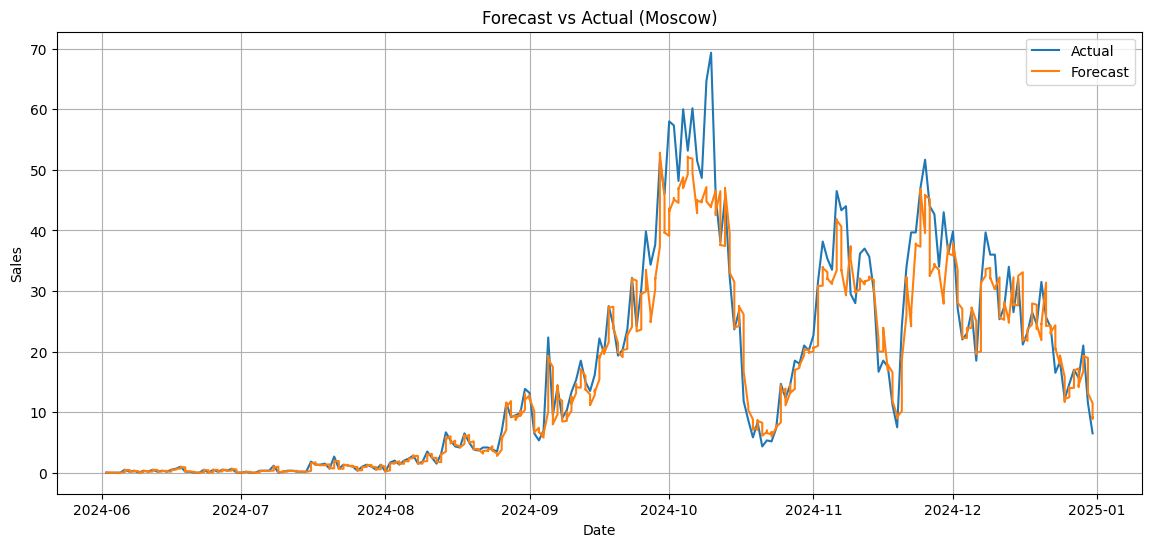

In [171]:
plt.figure(figsize=(14, 6))
plt.plot(df["date"][-len(y_test):], y_test, label="Actual")
plt.plot(df["date"][-len(y_test):], y_pred, label="Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Forecast vs Actual (Moscow)")
plt.legend()
plt.grid(True)
plt.show()